# Notebook summary
**Author:** Emily Diaz Badilla

**Objective:** Create a linear regression model in python

**Dataset:** 

Link: https://scikit-learn.org/stable/datasets/real_world.html#california-housing-dataset  

Sources: 
- https://jeffmacaluso.github.io/post/LinearRegressionAssumptions/ 

# Libraries

In [ ]:
import pandas as pd
import numpy as np
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import MinMaxScaler 
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_percentage_error

# Functions

In [ ]:
def calculate_residuals(model, features, label):
    """
    Creates predictions on the features with the model and calculates residuals
    """
    predictions = model.predict(features)
    df_results = pd.DataFrame({'Actual': label, 'Predicted': predictions})
    df_results['Residuals'] = abs(df_results['Actual']) - abs(df_results['Predicted'])
    
    return df_results

In [ ]:
def linear_assumption(model, features, label):
    """
    Linearity: Assumes that there is a linear relationship between the predictors and
               the response variable. If not, either a quadratic term or another
               algorithm should be used.
    """
    print('Assumption 1: Linear Relationship between the Target and the Feature', '\n')
        
    print('Checking with a scatter plot of actual vs. predicted.',
           'Predictions should follow the diagonal line.')
    
    # Calculating residuals for the plot
    df_results = calculate_residuals(model, features, label)
    
    # Plotting the actual vs predicted values
    sns.lmplot(x='Actual', y='Predicted', data=df_results, fit_reg=False, size=7)
        
    # Plotting the diagonal line
    line_coords = np.arange(df_results.min().min(), df_results.max().max())
    plt.plot(line_coords, line_coords,  # X and y points
             color='darkorange', linestyle='--')
    plt.title('Actual vs. Predicted')
    plt.show()

In [ ]:
def normal_errors_assumption(model, features, label, p_value_thresh=0.05):
    """
    Normality: Assumes that the error terms are normally distributed. If they are not,
    nonlinear transformations of variables may solve this.
               
    This assumption being violated primarily causes issues with the confidence intervals
    """
    from statsmodels.stats.diagnostic import normal_ad
    print('Assumption 2: The error terms are normally distributed', '\n')
    
    # Calculating residuals for the Anderson-Darling test
    df_results = calculate_residuals(model, features, label)
    
    print('Using the Anderson-Darling test for normal distribution')

    # Performing the test on the residuals
    p_value = normal_ad(df_results['Residuals'])[1]
    print('p-value from the test - below 0.05 generally means non-normal:', p_value)
    
    # Reporting the normality of the residuals
    if p_value < p_value_thresh:
        print('Residuals are not normally distributed')
    else:
        print('Residuals are normally distributed')
    
    # Plotting the residuals distribution
    plt.subplots(figsize=(12, 6))
    plt.title('Distribution of Residuals')
    sns.distplot(df_results['Residuals'])
    plt.show()
    
    print()
    if p_value > p_value_thresh:
        print('Assumption satisfied')
    else:
        print('Assumption not satisfied')
        print()
        print('Confidence intervals will likely be affected')
        print('Try performing nonlinear transformations on variables')

In [ ]:
def multicollinearity_assumption(model, features, label, feature_names=None):
    """
    Multicollinearity: Assumes that predictors are not correlated with each other. If there is
                       correlation among the predictors, then either remove prepdictors with high
                       Variance Inflation Factor (VIF) values or perform dimensionality reduction
                           
                       This assumption being violated causes issues with interpretability of the 
                       coefficients and the standard errors of the coefficients.
    """
    from statsmodels.stats.outliers_influence import variance_inflation_factor
    print('Assumption 3: Little to no multicollinearity among predictors')
        
    # Plotting the heatmap
    plt.figure(figsize = (10,8))
    sns.heatmap(pd.DataFrame(features, columns=feature_names).corr(), annot=True)
    plt.title('Correlation of Variables')
    plt.show()
        
    print('Variance Inflation Factors (VIF)')
    print('> 10: An indication that multicollinearity may be present')
    print('> 100: Certain multicollinearity among the variables')
    print('-------------------------------------')
       
    # Gathering the VIF for each variable
    VIF = [variance_inflation_factor(features, i) for i in range(features.shape[1])]
    for idx, vif in enumerate(VIF):
        print('{0}: {1}'.format(feature_names[idx], vif))
        
    # Gathering and printing total cases of possible or definite multicollinearity
    possible_multicollinearity = sum([1 for vif in VIF if vif > 10])
    definite_multicollinearity = sum([1 for vif in VIF if vif > 100])
    print()
    print('{0} cases of possible multicollinearity'.format(possible_multicollinearity))
    print('{0} cases of definite multicollinearity'.format(definite_multicollinearity))
    print()

    if definite_multicollinearity == 0:
        if possible_multicollinearity == 0:
            print('Assumption satisfied')
        else:
            print('Assumption possibly satisfied')
            print()
            print('Coefficient interpretability may be problematic')
            print('Consider removing variables with a high Variance Inflation Factor (VIF)')

    else:
        print('Assumption not satisfied')
        print()
        print('Coefficient interpretability will be problematic')
        print('Consider removing variables with a high Variance Inflation Factor (VIF)')

In [ ]:
def autocorrelation_assumption(model, features, label):
    """
    Autocorrelation: Assumes that there is no autocorrelation in the residuals. If there is
                     autocorrelation, then there is a pattern that is not explained due to
                     the current value being dependent on the previous value.
                     This may be resolved by adding a lag variable of either the dependent
                     variable or some of the predictors.
    """
    from statsmodels.stats.stattools import durbin_watson
    print('Assumption 4: No Autocorrelation', '\n')
    
    # Calculating residuals for the Durbin Watson-tests
    df_results = calculate_residuals(model, features, label)

    print('\nPerforming Durbin-Watson Test')
    print('Values of 1.5 < d < 2.5 generally show that there is no autocorrelation in the data')
    print('0 to 2< is positive autocorrelation')
    print('>2 to 4 is negative autocorrelation')
    print('-------------------------------------')
    durbinWatson = durbin_watson(df_results['Residuals'])
    print('Durbin-Watson:', durbinWatson)
    if durbinWatson < 1.5:
        print('Signs of positive autocorrelation', '\n')
        print('Assumption not satisfied')
    elif durbinWatson > 2.5:
        print('Signs of negative autocorrelation', '\n')
        print('Assumption not satisfied')
    else:
        print('Little to no autocorrelation', '\n')
        print('Assumption satisfied')

In [ ]:
def homoscedasticity_assumption(model, features, label):
    """
    Homoscedasticity: Assumes that the errors exhibit constant variance
    """
    print('Assumption 5: Homoscedasticity of Error Terms', '\n')
    
    print('Residuals should have relative constant variance')
        
    # Calculating residuals for the plot
    df_results = calculate_residuals(model, features, label)

    # Plotting the residuals
    plt.subplots(figsize=(12, 6))
    ax = plt.subplot(111)  # To remove spines
    plt.scatter(x=df_results.index, y=df_results.Residuals, alpha=0.5)
    plt.plot(np.repeat(0, df_results.index.max()), color='darkorange', linestyle='--')
    ax.spines['right'].set_visible(False)  # Removing the right spine
    ax.spines['top'].set_visible(False)  # Removing the top spine
    plt.title('Residuals')
    plt.show()  

## Google colab


# Loading Data

In [ ]:
data = fetch_california_housing()
df = pd.DataFrame(data=data.data, columns=data.feature_names)
print(df.shape)
df.head()

(20640, 8)


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


# EDA

In [ ]:
df.describe()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,3.870671,28.639486,5.429000,1.096675,1425.476744,3.070655,35.631861,-119.569704
std,1.899822,12.585558,2.474173,0.473911,1132.462122,10.386050,2.135952,2.003532
min,0.499900,1.000000,0.846154,0.333333,3.000000,0.692308,32.540000,-124.350000
25%,2.563400,18.000000,4.440716,1.006079,787.000000,2.429741,33.930000,-121.800000
50%,3.534800,29.000000,5.229129,1.048780,1166.000000,2.818116,34.260000,-118.490000
75%,4.743250,37.000000,6.052381,1.099526,1725.000000,3.282261,37.710000,-118.010000
max,15.000100,52.000000,141.909091,34.066667,35682.000000,1243.333333,41.950000,-114.310000


# Data Prep

In [ ]:
# Split
X = df.drop(columns= ['MedInc'])
y = df["MedInc"]

## Scaling

In [ ]:
# Initialize min/max scaler: this takes data to a 0 to 1 scale
scaler = MinMaxScaler()
scaled_X = scaler.fit_transform(X)

## Train test split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.3, random_state=1234)

# Model Fitting

In [ ]:
# Initialize
lr_model = LinearRegression()
# Fitting
lr_model.fit(X_train, y_train)


LinearRegression()

## Model Assumptions

**Linearity**

Assumption 1: Linear Relationship between the Target and the Feature 

Checking with a scatter plot of actual vs. predicted. Predictions should follow the diagonal line.


/usr/local/lib/python3.7/dist-packages/seaborn/regression.py:581: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


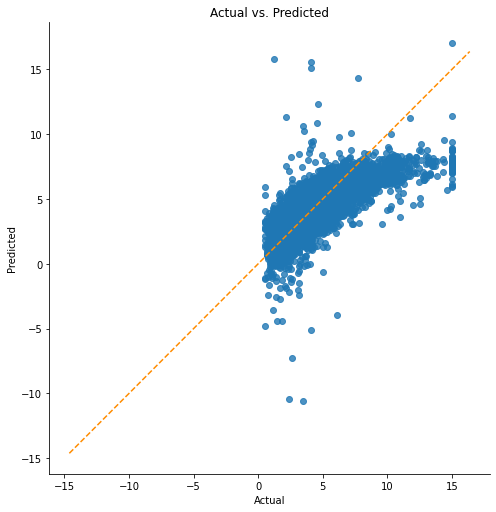

In [ ]:
linear_assumption(lr_model, X_train, y_train)

Not linear

**Normality of Residuals**

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Assumption 2: The error terms are normally distributed 

Using the Anderson-Darling test for normal distribution
p-value from the test - below 0.05 generally means non-normal: 0.0
Residuals are not normally distributed


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


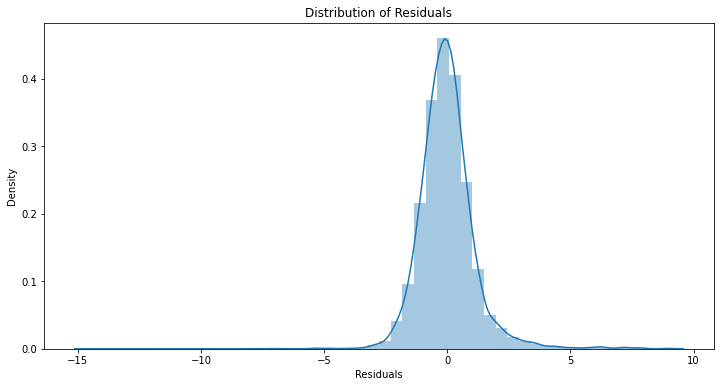


Assumption not satisfied

Confidence intervals will likely be affected
Try performing nonlinear transformations on variables


In [ ]:
normal_errors_assumption(lr_model, X_train, y_train)

**Multicollinearity**

Assumption 3: Little to no multicollinearity among predictors


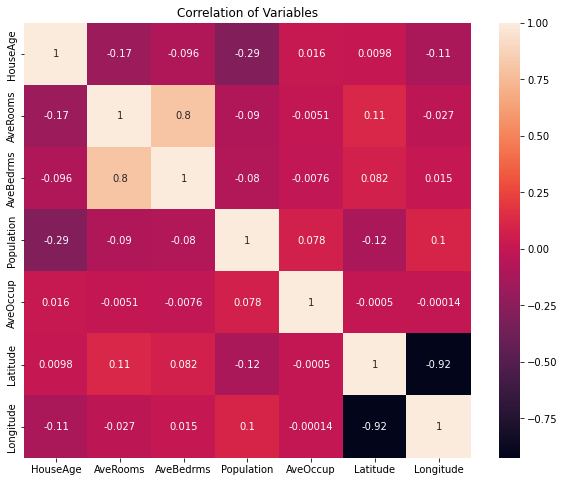

Variance Inflation Factors (VIF)
> 10: An indication that multicollinearity may be present
> 100: Certain multicollinearity among the variables
-------------------------------------
HouseAge: 5.395022936781813
AveRooms: 15.516189004197512
AveBedrms: 13.234824990505956
Population: 2.724070712496595
AveOccup: 1.0527560335438508
Latitude: 4.4262845780677615
Longitude: 7.735838955711175

2 cases of possible multicollinearity
0 cases of definite multicollinearity

Assumption possibly satisfied

Coefficient interpretability may be problematic
Consider removing variables with a high Variance Inflation Factor (VIF)


In [ ]:
multicollinearity_assumption(lr_model, X_train, y_train, X.columns)

**Autocorrelation of residuals**

In [ ]:
autocorrelation_assumption(lr_model, X_train, y_train)

Assumption 4: No Autocorrelation 


Performing Durbin-Watson Test
Values of 1.5 < d < 2.5 generally show that there is no autocorrelation in the data
0 to 2< is positive autocorrelation
>2 to 4 is negative autocorrelation
-------------------------------------
Durbin-Watson: 2.01744667914222
Little to no autocorrelation 

Assumption satisfied


**Homoscedasticity**

Assumption 5: Homoscedasticity of Error Terms 

Residuals should have relative constant variance


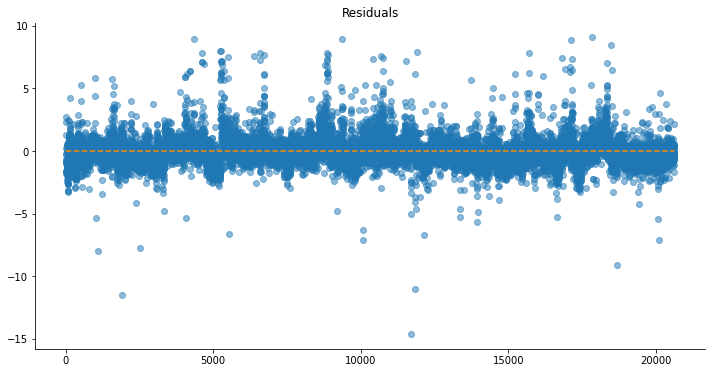

In [ ]:
homoscedasticity_assumption(lr_model, X_train, y_train)

# Model evaluation

In [ ]:
# R2
r2_train = lr_model.score(X_train, y_train)
print('Training R^2: {0}'.format(round(r2_train,4)))

r2_test = lr_model.score(X_test, y_test)
print('Testing R^2: {0}'.format(round(r2_test,4)))

Training R^2: 0.6161
Testing R^2: 0.5593


In [ ]:
# MAPE 
y_train_pred = lr_model.predict(X_train)
y_test_pred = lr_model.predict(X_test)
mape_train = mean_absolute_percentage_error(y_train, y_train_pred)
mape_test = mean_absolute_percentage_error(y_test, y_test_pred)

print("MAPE train: " + str(round(mape_train,4)*100) + "%")
print("MAPE test: " + str(round(mape_test,4)*100)+ "%")

MAPE train: 25.46%
MAPE test: 25.35%


# Model prediction

Text(0, 0.5, 'Predicted')

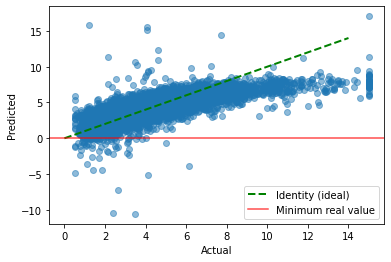

In [73]:
# Plot predicted vs real
plt.scatter(y_train, y_train_pred, alpha= 0.5)
plt.plot( [0,14],[0,14] , c = "green", linestyle='dashed', linewidth = 2,  label="Identity (ideal)")
plt.axhline(y=0, color='red', linestyle='-', alpha=0.7,  label="Minimum real value")
plt.legend()
plt.xlabel("Actual")
plt.ylabel("Predicted")